In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [67]:
# 파일 불러오기
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv', encoding='latin1')
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 5572


In [68]:
# 데이터 확인하기
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [70]:
# Column 선택하기
data = data[['v1', 'v2']]
# ham, spam을 정수로 대체하기
data['v1'] = data['v1'].replace(['ham', 'spam'], [0,1])
data.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [72]:
print('결측값 여부 :', data.isnull().values.any())
# isnull()을 하면 true or false로 출력
# values는 frame 형태가 아닌 값을 출력
# any() 어떠한 값이 있냐?

결측값 여부 : False


In [73]:
print('v2열의 유니크한 값 : ', data['v2'].nunique())
# number of unique 값 출력

v2열의 유니크한 값 :  5169


In [74]:
# 중복된 값 제거하기
data.drop_duplicates(subset =['v2'], inplace = True)

In [75]:
print('정상 메일과 스팸 메일의 개수')
print(data.groupby('v1').size().reset_index(name='count'))
print(35*'-')
print(f'정상 메일의 비율 = {round(data["v1"].value_counts()[0]/len(data) * 100,3)}%')
print(f'스팸 메일의 비율 = {round(data["v1"].value_counts()[1]/len(data) * 100,3)}%')

정상 메일과 스팸 메일의 개수
   v1  count
0   0   4516
1   1    653
-----------------------------------
정상 메일의 비율 = 87.367%
스팸 메일의 비율 = 12.633%


In [14]:
X_data = data['v2']
y_data = data['v1']
print('메일 본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

메일 본문의 개수: 5169
레이블의 개수: 5169


------

In [76]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer # 정규식을 이용한 단어 분리

# 유니코드보다 작은 값 제거하기
def _removeNonAscii(s):
    return "".join(i for i in s if ord(i)<128) 
    # ord() 유티코드 정수 반환
    # 한 문자씩(a,b,c) 변환
    
# 소문자화
def make_lower_case(text):
    return text.lower()
    # text 전체 적용

# 불용어 제거
def remove_stop_words(text):
    text = text.split() # 하나의 데이터를 나누어주고
    stops = set(stopwords.words('english'))
    text = [w for w in text if not w in stops] # 불용어인 것을 제거한다.
    text = ' '.join(text) # 다시 하나의 text로 만든다.
    return text

# 특수문자 제거하기
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [77]:
data['cleaned'] = data['v2'].apply(_removeNonAscii)
data['cleaned'] = data.cleaned.apply(make_lower_case)
data['cleaned'] = data.cleaned.apply(remove_stop_words)
data['cleaned'] = data.cleaned.apply(remove_punctuation)
data.head()

,v1,v2,cleaned
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goes usf lives around though


In [100]:
# 데이터와 레이블 분류하기
X_data = data['cleaned']
y_data = data['v1']

# fit_on_texts는 입력한 텍스트로부터 단어 빈도수가 높은 순으로 낮은 정수 인덱스를 부여하는 과정입니다.
# 정확히 앞서 설명한 정수 인코딩 작업이 이루어진다고 보면됩니다. 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data)

#Sequence화 하기
X_data_encoded = tokenizer.texts_to_sequences(X_data)

# {word, index}
word_to_index = tokenizer.word_index
print('총 단어의 수: ', len(word_to_index))

# trian, test 데이터 분류하기
X_train, X_test, y_train, y_test = train_test_split(X_data_encoded, y_data, test_size=0.2, random_state=0, stratify=y_data)

총 단어의 수:  7690


In [82]:
print('기존 데이터에서 메일의 최대 길이 : %d' % max(len(sample) for sample in X_data_encoded))
print('기존 데이터에서 메일의 평균 길이 : %f' % (sum(map(len, X_train_encoded))/len(X_data_encoded)))

기존 데이터에서 메일의 최대 길이 : 97
기존 데이터에서 메일의 평균 길이 : 7.810408


# 희귀 단어를 제거하는 과정

In [83]:
threshold = 2 # 단어 빈도 수
total_cnt = len(word_to_index) # 총 단어 수
rare_cnt = 0 # 등장 빈도수가 적은 rare 단어의 수
total_freq = 0 # 전체 단어의 카운트 수
rare_freq = 0 # 등장 빈도수가 적은 rare 단어의 카운트 수

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    if value < threshold:
        rare_cnt += 1
        rare_freq += value
        
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 4098
단어 집합(vocabulary)에서 희귀 단어의 비율: 53.289986996098826
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.178498014249506


In [84]:
#희귀 단어 제거
rare_word_idx = []

for key, value in tokenizer.word_counts.items():
    if value < threshold:
        # 인덱스 가져오기
        rare_word_idx.append(word_to_index[key])
        
# 희귀 단어 인덱스 만들기
print('희귀 단어의 개수:', len(rare_word_idx))

희귀 단어의 개수: 4098


In [91]:
# 총 단어의 수에서 빈도가 적은 희귀 단어를 제거한다.
# 패딩을 위한 단어도 포함한다.
vocab_size = len(word_to_index) - len(rare_word_idx) + 1
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 3593


In [96]:
# 희귀 단어를 제거한 Sequence 데이터를 만든다.
new_X_encoded = []

for sequence in X_data_encoded:
    new_sequence = [i for i in sequence if i not in rare_word_idx]
    new_X_encoded.append(new_sequence)

# 총 메일의 수
print('총 메일의 수: ', len(new_X_train_encoded))

총 메일의 수:  5169


In [97]:
print('희귀 단어를 제거한 메일의 최대 길이 : %d' % max(len(mail) for mail in new_X_encoded))
print('희귀 단어를 제거한 메일메일의 평균 길이 : %f' % (sum(map(len, new_X_encoded))/len(new_X_encoded)))

희귀 단어를 제거한 메일의 최대 길이 : 91
희귀 단어를 제거한 메일메일의 평균 길이 : 8.900948


In [105]:
# padding 
max_len = 91

X_padded = pad_sequences(new_X_encoded, maxlen = max_len)
print("훈련 데이터의 shape: ", X_train_padded.shape)

훈련 데이터의 shape:  (5169, 91)


In [106]:
# trian, test 데이터 분류하기
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_data, test_size=0.2, random_state=0, stratify=y_data)

In [109]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (4135, 91)
훈련 샘플 레이블의 크기 : (4135,)
테스트 샘플 문장의 크기 : (1034, 91)
테스트 샘플 레이블의 크기 : (1034,)


--------

In [115]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

embedding_dim = 32
hidden_units = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim)) # 임베딩
model.add(SimpleRNN(hidden_units)) # RNN 모델
model.add(Dense(1, activation = 'sigmoid')) # 0,1 classification

model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
             metrics = ['acc'])

history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
52/52 [==============================] - 2s 15ms/step - loss: 0.4362 - acc: 0.8597 - val_loss: 0.2912 - val_acc: 0.9178
Epoch 2/10
52/52 [==============================] - 1s 12ms/step - loss: 0.1806 - acc: 0.9619 - val_loss: 0.1273 - val_acc: 0.9734
Epoch 3/10
52/52 [==============================] - 1s 13ms/step - loss: 0.1094 - acc: 0.9761 - val_loss: 0.0992 - val_acc: 0.9782
Epoch 4/10
52/52 [==============================] - 1s 13ms/step - loss: 0.0576 - acc: 0.9900 - val_loss: 0.0800 - val_acc: 0.9782
Epoch 5/10
52/52 [==============================] - 1s 13ms/step - loss: 0.0365 - acc: 0.9927 - val_loss: 0.0683 - val_acc: 0.9807
Epoch 6/10
52/52 [==============================] - 1s 13ms/step - loss: 0.0232 - acc: 0.9964 - val_loss: 0.0623 - val_acc: 0.9843
Epoch 7/10
52/52 [==============================] - 1s 13ms/step - loss: 0.0169 - acc: 0.9973 - val_loss: 0.0605 - val_acc: 0.9843
Epoch 8/10
52/52 [==============================] - 1s 13ms/step - loss: 0.0124 - a

In [116]:
# test 데이터로 확인하기
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

33/33 [==============================] - 0s 3ms/step - loss: 0.0680 - acc: 0.9826

 테스트 정확도: 0.9826


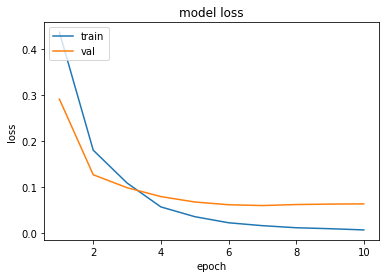

In [117]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()